# Extract features

In [2]:
from utils.file_reading import read_edus, read_annotation

In [3]:
from glob import glob
import pandas as pd


def extract_triplets(edus, annot):
    triplets = []
    cursor = 0
    
    for sentence in range(len(annot['sentences'])):
        for token in range(annot['sentences'][sentence].begin, annot['sentences'][sentence].end):
            if token == annot['sentences'][sentence].begin:
                if token > 0:
                    left_neighbour = (#annot['tokens'][token-1].text,
                                      annot['lemma'][sentence-1][-1],
                                      annot['postag'][sentence-1][-1],
                                      annot['syntax_dep_tree'][sentence-1][-1].link_name)
                    original_text = annot['text'][annot['tokens'][token-1].begin:annot['tokens'][token].end]
                else:
                    left_neighbour = ('', '', '')
                    original_text = annot['text'][annot['tokens'][token].begin:annot['tokens'][token].end]
            else:
                left_neighbour = (#annot['tokens'][token-1].text,
                                  annot['lemma'][sentence][token-1-annot['sentences'][sentence].begin],
                                  annot['postag'][sentence][token-1-annot['sentences'][sentence].begin],
                                  annot['syntax_dep_tree'][sentence][token-1-annot['sentences'][sentence].begin].link_name)
                original_text = annot['text'][annot['tokens'][token-1].begin:annot['tokens'][token].end]
                
            token_itself = (#annot['tokens'][token].text, 
                            annot['lemma'][sentence][token-annot['sentences'][sentence].begin],
                            annot['postag'][sentence][token-annot['sentences'][sentence].begin],
                            annot['syntax_dep_tree'][sentence][token-annot['sentences'][sentence].begin].link_name)
            
            if token == annot['sentences'][sentence].end-1:
                if token + 1 < len(annot['tokens']):
                    right_neighbour = (#annot['tokens'][token+1].text, 
                                       annot['lemma'][sentence+1][0],
                                        annot['postag'][sentence+1][0],
                                        annot['syntax_dep_tree'][sentence+1][0].link_name)
                    original_text += annot['text'][annot['tokens'][token].end:annot['tokens'][token+1].end]
                else:
                    right_neighbour = ('', '', '')
            else:
                right_neighbour = (#annot['tokens'][token+1].text, 
                                    annot['lemma'][sentence][token+1-annot['sentences'][sentence].begin],
                                   annot['postag'][sentence][token+1-annot['sentences'][sentence].begin],
                                   annot['syntax_dep_tree'][sentence][token+1-annot['sentences'][sentence].begin].link_name)
                original_text += annot['text'][annot['tokens'][token].end:annot['tokens'][token+1].end]

            if cursor < len(edus):
                if edus[cursor].endswith(original_text) or original_text.endswith(edus[cursor]):
                    marker = 1
                    cursor += 1
                else:
                    marker = 0
            else:
                marker = 1
                
            triplets.append(left_neighbour + token_itself + right_neighbour + (marker,))
            del left_neighbour, token_itself, right_neighbour, marker
                
            if cursor > len(edus):
                break

    return triplets

### Split dataset as everywhere in this directory 

In [4]:
import glob
import os

files = sorted(glob.glob('data/*.edus'), key=lambda s: int(s.split('.')[-2][-1]))
test = files[::5]
train = [file for file in files if not file in test]

In [5]:
train

['data/news1_20.edus',
 'data/blogs_10.edus',
 'data/sci.comp_20.edus',
 'data/news1_50.edus',
 'data/sci.comp_50.edus',
 'data/sci.ling_30.edus',
 'data/blogs_50.edus',
 'data/blogs_20.edus',
 'data/news1_60.edus',
 'data/news2_20.edus',
 'data/news1_70.edus',
 'data/news1_30.edus',
 'data/news2_10.edus',
 'data/blogs_30.edus',
 'data/blogs_100.edus',
 'data/news1_10.edus',
 'data/sci.ling_20.edus',
 'data/sci.comp_10.edus',
 'data/blogs_70.edus',
 'data/news2_0.edus',
 'data/sci.comp_40.edus',
 'data/blogs_40.edus',
 'data/news2_40.edus',
 'data/blogs_21.edus',
 'data/news1_71.edus',
 'data/blogs_51.edus',
 'data/news2_11.edus',
 'data/sci.comp_31.edus',
 'data/sci.comp_51.edus',
 'data/blogs_71.edus',
 'data/news1_41.edus',
 'data/sci.ling_21.edus',
 'data/sci.ling_11.edus',
 'data/sci.comp_21.edus',
 'data/blogs_11.edus',
 'data/news1_61.edus',
 'data/blogs_101.edus',
 'data/sci.comp_1.edus',
 'data/news1_31.edus',
 'data/news1_21.edus',
 'data/news1_1.edus',
 'data/news1_11.edus',

In [6]:
triplets_bank = []

for file in train:
    filename = file[:file.rfind('.edus')]
    edus = read_edus(filename)
    annot = read_annotation(filename)
    triplets = extract_triplets(edus, annot)
    triplets_bank += triplets
    
train = pd.DataFrame(triplets_bank, columns=['left_token', 'left_pos', 'left_link', 
                                             'token', 'pos', 'link', 
                                             'right_token', 'right_pos', 'right_link', 'class'])

In [7]:
train = pd.DataFrame(triplets_bank, columns=['left_token', 'left_pos', 'left_link', 
                                             'token', 'pos', 'link', 
                                             'right_token', 'right_pos', 'right_link', 'class'])

In [8]:
test = files[::5]

In [9]:
triplets_bank = []

for file in test:
    filename = file[:file.rfind('.edus')]
    edus = read_edus(filename)
    annot = read_annotation(filename)
    triplets = extract_triplets(edus, annot)
    triplets_bank += triplets
    
test = pd.DataFrame(triplets_bank, columns=['left_token', 'left_pos', 'left_link', 
                                            'token', 'pos', 'link', 
                                            'right_token', 'right_pos', 'right_link', 'class'])

In [10]:
train.shape, test.shape

((343796, 10), (95323, 10))

In [11]:
train.head()

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class
0,,,,иерусалим,NOUN,nsubj,–,,punct,0
1,иерусалим,NOUN,nsubj,–,,punct,как,CONJ,nsubj,0
2,–,,punct,как,CONJ,nsubj,обнаруживать,VERB,root,0
3,как,CONJ,nsubj,обнаруживать,VERB,root,посол,NOUN,obj,0
4,обнаруживать,VERB,root,посол,NOUN,obj,по,ADP,case,0


In [12]:
train['class'].value_counts()

0    319138
1     24658
Name: class, dtype: int64

In [13]:
test['class'].value_counts()

0    88428
1     6895
Name: class, dtype: int64

### Embed 

In [14]:
from gensim.models import Word2Vec, KeyedVectors

#embed_model_path = 'models_w2v/ruwikiruscorpora_upos_cbow_300_20_2017.bin'
#word2vec_model = KeyedVectors.load_word2vec_format(embed_model_path, binary=embed_model_path[-4:] == '.bin')

embed_model_path='models/w2v/segmentator/model2_tokenized'
word2vec_model = Word2Vec.load(embed_model_path)

In [15]:
import numpy as np

def get_embeddings(embedder, word):
    try:
        return embedder[word.lower()]
    except KeyError:
        return np.zeros(embedder.vector_size)

In [16]:
tag_for_embeddings = False

if tag_for_embeddings:
    train['e_left'] = train.apply(lambda row: get_embeddings(word2vec_model, '_'.join([row.left_token, row.left_pos])), axis=1)
else:
    train['e_left'] = train.left_token.map(lambda row: get_embeddings(word2vec_model, row))
    train['e_token'] = train.token.map(lambda row: get_embeddings(word2vec_model, row))
    train['e_right'] = train.right_token.map(lambda row: get_embeddings(word2vec_model, row))
    test['e_left'] = test.left_token.map(lambda row: get_embeddings(word2vec_model, row))
    test['e_token'] = test.token.map(lambda row: get_embeddings(word2vec_model, row))
    test['e_right'] = test.right_token.map(lambda row: get_embeddings(word2vec_model, row))

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [17]:
train.tail()

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class,e_left,e_token,e_right
343791,единый,ADJ,amod,и,CONJ,cc,не,PART,advmod,0,"[-0.29361126, -2.558814, 6.081241, -2.4535708,...","[0.029717546, -0.43479246, 4.4642878, -2.25146...","[2.6961708, 0.584439, 2.2304404, -3.7900112, 2..."
343792,и,CONJ,cc,не,PART,advmod,только,PART,conj,0,"[0.029717546, -0.43479246, 4.4642878, -2.25146...","[2.6961708, 0.584439, 2.2304404, -3.7900112, 2...","[0.17619395, -0.58183616, 0.21602416, 1.413770..."
343793,не,PART,advmod,только,PART,conj,антидепрессант,NOUN,iobj,0,"[2.6961708, 0.584439, 2.2304404, -3.7900112, 2...","[0.17619395, -0.58183616, 0.21602416, 1.413770...","[0.016394, -1.0524415, -0.33453575, -2.0902574..."
343794,только,PART,conj,антидепрессант,NOUN,iobj,...,,punct,1,"[0.17619395, -0.58183616, 0.21602416, 1.413770...","[0.016394, -1.0524415, -0.33453575, -2.0902574...","[0.73374593, 1.3508228, 4.759483, 0.38425514, ..."
343795,антидепрессант,NOUN,iobj,...,,punct,,,,1,"[0.016394, -1.0524415, -0.33453575, -2.0902574...","[0.73374593, 1.3508228, 4.759483, 0.38425514, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
test.tail()

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class,e_left,e_token,e_right
95318,",",,punct,1998,,root,.,,punct,0,"[-0.4151887, -0.49132088, 1.7798588, -2.808686...","[2.7322314, -1.6239583, 0.2196038, 0.19036172,...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3..."
95319,1998,,root,.,,punct,700,,nummod:gov,0,"[2.7322314, -1.6239583, 0.2196038, 0.19036172,...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[-1.3842758, -3.251603, 0.043013178, -4.626958..."
95320,.,,punct,700,,nummod:gov,с,NOUN,root,1,"[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[-1.3842758, -3.251603, 0.043013178, -4.626958...","[5.232198, -3.273452, 2.0625587, 3.5914886, -1..."
95321,700,,nummod:gov,с,NOUN,root,.,,punct,1,"[-1.3842758, -3.251603, 0.043013178, -4.626958...","[5.232198, -3.273452, 2.0625587, 3.5914886, -1...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3..."
95322,с,NOUN,root,.,,punct,,,,1,"[5.232198, -3.273452, 2.0625587, 3.5914886, -1...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
import pickle
    
#not_categ_features = {'arg_address', 'ex_id', 'rel_pos'}

categ_feats = ['left_pos', 'left_link',
               'pos', 'link',
               'right_pos', 'right_link']

print('Category features:\n', categ_feats)
#print('Not category features:\n', not_categ)

vectorizer = DictVectorizer(sparse=False)
vectorizer.fit(train[categ_feats].to_dict(orient='records'))
one_hot_feats = vectorizer.transform(train[categ_feats].to_dict(orient='records'))
print(one_hot_feats.shape)

main_model_path = 'models/segmentator/'
! mkdir $main_model_path

with open(main_model_path + 'vectorizer.pckl', 'wb') as f:
    pickle.dump(vectorizer, f)

Category features:
 ['left_pos', 'left_link', 'pos', 'link', 'right_pos', 'right_link']
(343796, 146)
mkdir: cannot create directory ‘models/segmentator/’: File exists


In [20]:
with open(main_model_path + 'category_features.pckl', 'wb') as f:
    pickle.dump(categ_feats, f)

In [21]:
one_hot_feats.shape

(343796, 146)

In [22]:
not_categ = ['left_token', 'token', 'right_token', 'class', 'e_left', 'e_token', 'e_right']

In [23]:
one_hot_test = vectorizer.transform(test[categ_feats].to_dict(orient='records'))

### Construct some models

In [41]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Input, Dense, concatenate, Conv1D, Conv2D, BatchNormalization, Activation, MaxPooling1D, \
    MaxPooling2D, Dropout, GlobalMaxPool2D, Flatten, Bidirectional, Conv1D, GlobalMaxPool1D, GlobalMaxPooling1D, \
    GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Lambda
from keras.layers import Permute
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import merge
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.regularizers import l2, l1
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

In [42]:
# Use only one GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../isanlp/src/')
sys.path.append('../../src/isanlp_srl_framebank/')
sys.path.append('../../libs/')
sys.path.append('../../libs/pylingtools/')

# Supress tensorflow memory appetites

import tensorflow as tf
print(tf.__version__)

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# config.log_device_placement=True
# sess = tf.Session(config=config)

# from tensorflow.python.keras import backend as K
# K.set_session(sess)

# Check available GPUs

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

2.1.0


['/device:GPU:0']

In [43]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [58]:
def construct_simple_model(input_length, plain_length, output_length):
    inner_size = 50
    dropout = .2
    
    input_token = Input(shape=(input_length,))
    l1 = BatchNormalization()(input_token)
    input_left = Input(shape=(input_length,))
    l2 = BatchNormalization()(input_left)
    input_right = Input(shape=(input_length,))
    l3 = BatchNormalization()(input_right)
    input_plain = Input(shape=(plain_length,))
    l4 = BatchNormalization()(input_plain)

    l1 = Dense(inner_size, activation='tanh')(l1)
    l1 = BatchNormalization()(l1)
    l1 = Activation('tanh')(l1)
    l1 = Dropout(dropout)(l1)
    l2 = Dense(inner_size)(l2)
    l2 = BatchNormalization()(l2)
    l2 = Activation('tanh')(l2)
    l2 = Dropout(dropout)(l2)
    l3 = Dense(inner_size)(l3)
    l3 = BatchNormalization()(l3)
    l3 = Activation('tanh')(l3)
    l3 = Dropout(dropout)(l3)
    l4 = Dense(int(inner_size * 1.5))(l4)
    l4 = BatchNormalization()(l4)
    l4 = Activation('tanh')(l4)
    l4 = Dropout(dropout)(l4)
    x = concatenate([l1, l2, l3, l4], axis=-1)
        
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=[input_token, input_left, input_right, input_plain], outputs=outputs)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [28]:
e_left_train = np.stack(train.e_left.values)
e_token_train = np.stack(train.e_token.values)
e_right_train = np.stack(train.e_right.values)

e_left_test = np.stack(test.e_left.values)
e_token_test = np.stack(test.e_token.values)
e_right_test = np.stack(test.e_right.values)

In [29]:
from keras.utils import to_categorical

y_train = to_categorical(train['class'].values)
y_test = to_categorical(test['class'].values)

In [29]:
model = construct_simple_model(input_length=e_left_train.shape[1],
                               plain_length=one_hot_feats.shape[1],
                              output_length=2)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(x=[e_token_train, e_left_train, e_right_train, one_hot_feats], 
                    y=y_train, epochs=25, batch_size=512, 
                    validation_data=([e_token_test, e_left_test, e_right_test, one_hot_test], y_test),
                    shuffle=True, callbacks = [early_stopping,],
                    class_weight={0:1, 1:14})

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 146)          0                                            
____________________________________________________________________________________________

In [111]:
predicted = model.predict([e_left_test, e_token_test, e_right_test, one_hot_test])  
pr_classes = np.argmax(predicted, axis=1)
y = np.argmax(y_test, axis=1)
print('weighted f1: ', f1_score(y, pr_classes, average='weighted'))
print(classification_report(y, pr_classes))

weighted f1:  0.8945263029785863
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     88428
           1       0.34      0.79      0.47      6895

    accuracy                           0.87     95323
   macro avg       0.66      0.83      0.70     95323
weighted avg       0.94      0.87      0.89     95323



### Add smote 

In [31]:
y_train.shape

(343796, 2)

In [33]:
! pip install -U imblearn

  Using cached scikit_learn-0.22.1-cp37-cp37m-manylinux1_x86_64.whl (7.0 MB)
ERROR: deeppavlov 0.7.1 requires fastapi==0.38.1, which is not installed.
ERROR: deeppavlov 0.7.1 requires fuzzywuzzy==0.17.0, which is not installed.
ERROR: deeppavlov 0.7.1 requires pymorphy2-dicts-ru, which is not installed.
ERROR: deeppavlov 0.7.1 requires pyopenssl==19.0.0, which is not installed.
ERROR: deeppavlov 0.7.1 requires pytelegrambotapi==3.6.6, which is not installed.
ERROR: deeppavlov 0.7.1 requires rusenttokenize==0.0.5, which is not installed.
ERROR: deeppavlov 0.7.1 requires uvicorn==0.9.0, which is not installed.
ERROR: mlxtend 0.17.1 has requirement matplotlib>=3.0.0, but you'll have matplotlib 2.1.2 which is incompatible.
ERROR: lightgbm 2.3.2 has requirement scikit-learn<=0.21.3, but you'll have scikit-learn 0.22.1 which is incompatible.
ERROR: dostoevsky 0.4.0 has requirement scikit-learn==0.21.3, but you'll have scikit-learn 0.22.1 which is incompatible.
ERROR: deeppavlov 0.7.1 has req

In [30]:
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

sm = SMOTE(random_state=42)
X = [np.concatenate([e_left_train[i], e_token_train[i], e_right_train[i], one_hot_feats[i]]) 
     for i in range(len(np.argmax(y_train, axis=1)))]
X_res, y_res = sm.fit_resample(X, y_train)

In [31]:
e_left_over = [emb[:100] for emb in X_res]
e_token_over = [emb[100:200] for emb in X_res]
e_right_over = [emb[200:300] for emb in X_res]
plain_over = [emb[300:] for emb in X_res]
y_over = to_categorical(y_res)

In [59]:
model = construct_simple_model(input_length=e_left_train.shape[1],
                               plain_length=one_hot_test.shape[1],
                              output_length=2)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, 
                               mode='auto', restore_best_weights=True)

history = model.fit(x=[e_token_over, e_left_over, e_right_over, plain_over], 
                    y=y_over, epochs=200, batch_size=256,# validation_split=0.1, 
                    validation_data=([e_token_test, e_left_test, e_right_test, one_hot_test],
                                     y_test),#, one_hot_test], y_test),
                    shuffle=True, callbacks = [early_stopping])

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 146)          0                                            
____________________________________________________________________________________________

638276/638276 [==============================] - 15s 24us/step - loss: 0.1862 - accuracy: 0.9288 - val_loss: 0.1892 - val_accuracy: 0.9310
Epoch 16/200
638276/638276 [==============================] - 15s 24us/step - loss: 0.1849 - accuracy: 0.9294 - val_loss: 0.2030 - val_accuracy: 0.9262
Epoch 17/200
638276/638276 [==============================] - 15s 24us/step - loss: 0.1833 - accuracy: 0.9302 - val_loss: 0.1725 - val_accuracy: 0.9393
Epoch 18/200
638276/638276 [==============================] - 15s 24us/step - loss: 0.1832 - accuracy: 0.9301 - val_loss: 0.1841 - val_accuracy: 0.9334
Epoch 19/200
638276/638276 [==============================] - 15s 24us/step - loss: 0.1822 - accuracy: 0.9302 - val_loss: 0.1975 - val_accuracy: 0.9261
Epoch 20/200
638276/638276 [==============================] - 15s 24us/step - loss: 0.1815 - accuracy: 0.9310 - val_loss: 0.2052 - val_accuracy: 0.9235
Epoch 21/200
638276/638276 [==============================] - 15s 24us/step - loss: 0.1804 - accuracy

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score

predicted = model.predict([e_left_test, e_token_test, e_right_test, one_hot_test])  
pr_classes = np.argmax(predicted, axis=1)
y = np.argmax(y_test, axis=1)

print('pr: ', precision_score(y, pr_classes))
print('re: ', recall_score(y, pr_classes))
print('f1: ', f1_score(y, pr_classes))
print()
print(classification_report(y, pr_classes))

pr:  0.5577019150707744
re:  0.4857142857142857
f1:  0.5192248062015504

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     88428
           1       0.56      0.49      0.52      6895

    accuracy                           0.93     95323
   macro avg       0.76      0.73      0.74     95323
weighted avg       0.93      0.93      0.93     95323



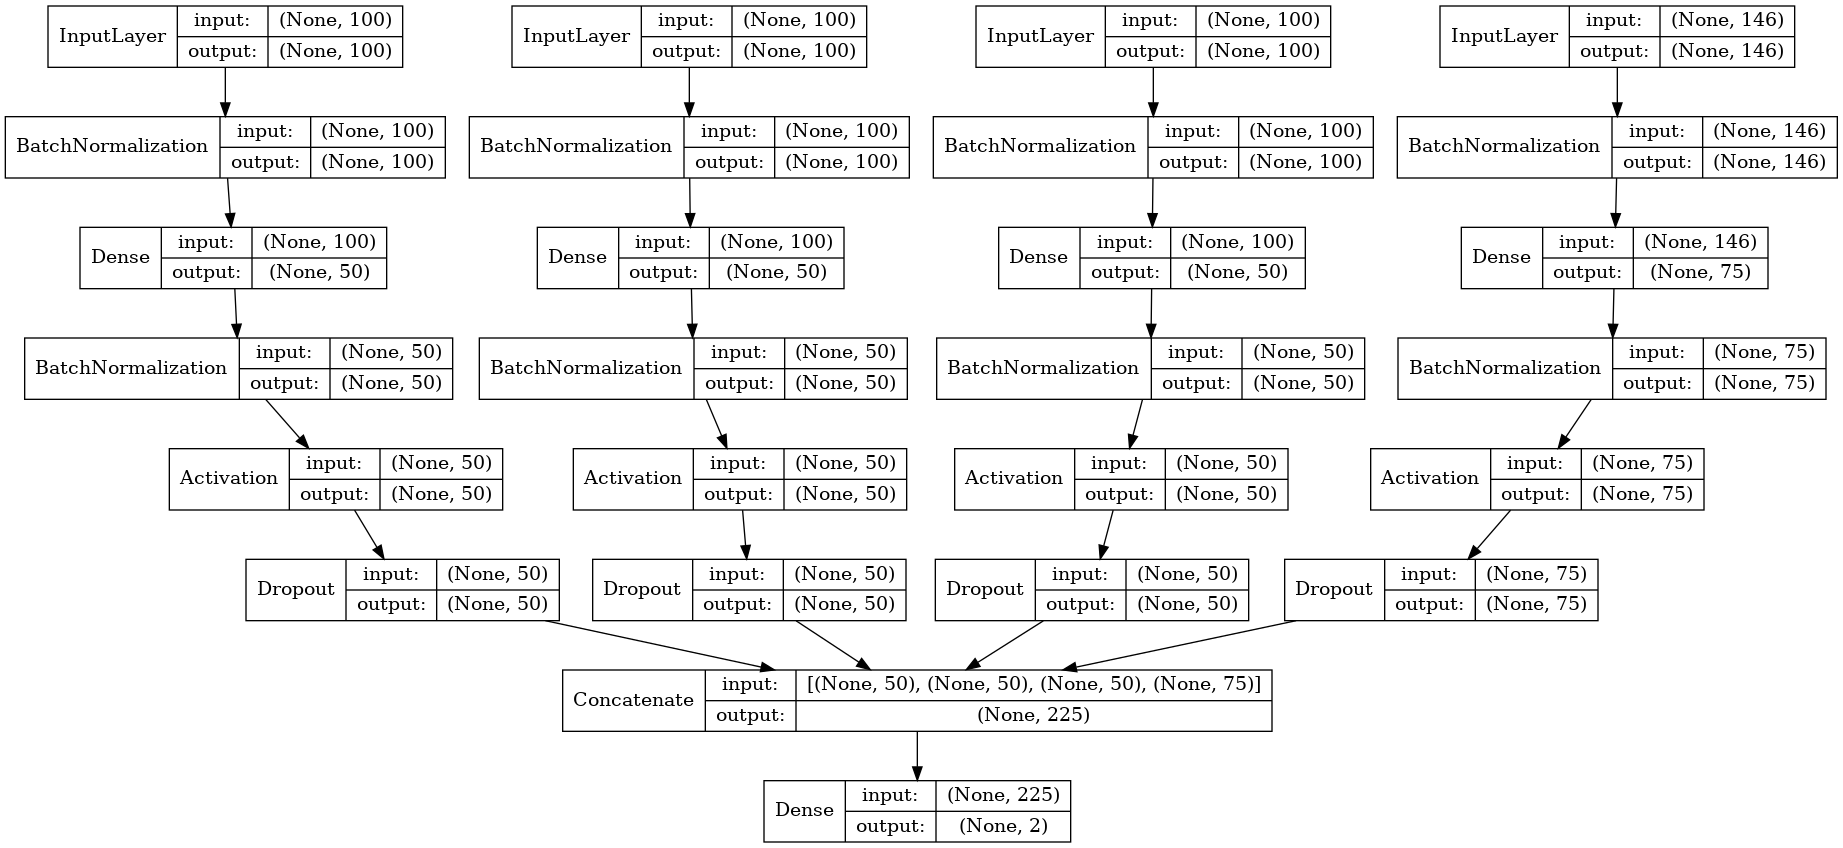

In [61]:
from keras.utils import plot_model
plot_model(model, to_file='models/segmentator/model.png', show_shapes=True, show_layer_names=False)

In [62]:
model.save('models/segmentator/neural_model.h5')

In [63]:
def triplets_to_text(data):
    text = []
    for i, row in data.iterrows():
        text.append(row.token)
        if row['class']:
            text.append('\n')
    return ' '.join(text)

In [64]:
result = test

In [65]:
result['class'] = y

In [66]:
result['class'] = pr_classes

In [67]:
plain = triplets_to_text(result)

In [68]:
plain[:1000]

'омер бичер \n пословица и поговорка с анималистический образ во фразеологический словарь адрес статья : www.gramota.net materials27201511 - 2735 \n . html источник филологический наука \n . вопрос теория и практика тамбов : грамота , \n 2015 . № 11 ( 53 ) : в 3 - х ч ч II . C . 136 - 138 \n . ISSN 1997 - 2911 \n . адрес журнал : www.gramota.net editions2 . \n html содержание данный номер журнал : www .gramota.net mate rials2201511 - 2 © издательство " грамота " информация о возможность публикация статья в журнал размещать на интернет сайт издательство : www.gramota.net вопрос , связывать с публикация научный материал , редакция просить направлять на адрес : phil@gramota.net УДК 8 ; 81 - 22 филологический наука в статья рассматриваться подход к описание фразеологический материал в современный одноязычный и двуязычный словарь с позиция взаимоотношение язык и культура \n . основной внимание уделяться пословица и поговорка как наиболее яркий носитель национальный - культурный семантика \n

In [69]:
with open('temp.temp', 'w') as f:
    f.write(plain)

In [70]:
temp = ('\n').join([unit.strip() for unit in plain.split('\n')])

In [71]:
test.head(100).tail(50)

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class,e_left,e_token,e_right
50,.,,punct,136,,root,-,,goeswith,0,"[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[-1.0378172, -0.7267874, -1.0725677, -3.036164...","[-1.5140693, 2.9516234, 2.7329545, -1.5181525,..."
51,136,,root,-,,goeswith,138,,goeswith,0,"[-1.0378172, -0.7267874, -1.0725677, -3.036164...","[-1.5140693, 2.9516234, 2.7329545, -1.5181525,...","[-1.2521603, -1.7641739, -0.7013659, -0.569381..."
52,-,,goeswith,138,,goeswith,.,,punct,1,"[-1.5140693, 2.9516234, 2.7329545, -1.5181525,...","[-1.2521603, -1.7641739, -0.7013659, -0.569381...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3..."
53,138,,goeswith,.,,punct,ISSN,,root,0,"[-1.2521603, -1.7641739, -0.7013659, -0.569381...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[0.013723274, -0.05973412, 0.040924005, 0.0002..."
54,.,,punct,ISSN,,root,1997,,appos,0,"[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[0.013723274, -0.05973412, 0.040924005, 0.0002...","[2.7251616, -2.2376978, 0.09326518, -1.6457143..."
55,ISSN,,root,1997,,appos,-,,goeswith,0,"[0.013723274, -0.05973412, 0.040924005, 0.0002...","[2.7251616, -2.2376978, 0.09326518, -1.6457143...","[-1.5140693, 2.9516234, 2.7329545, -1.5181525,..."
56,1997,,appos,-,,goeswith,2911,,goeswith,0,"[2.7251616, -2.2376978, 0.09326518, -1.6457143...","[-1.5140693, 2.9516234, 2.7329545, -1.5181525,...","[-0.22624724, 0.074626856, 0.063848674, -0.056..."
57,-,,goeswith,2911,,goeswith,.,,punct,1,"[-1.5140693, 2.9516234, 2.7329545, -1.5181525,...","[-0.22624724, 0.074626856, 0.063848674, -0.056...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3..."
58,2911,,goeswith,.,,punct,адрес,NOUN,root,0,"[-0.22624724, 0.074626856, 0.063848674, -0.056...","[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[-2.0146544, -3.637048, -0.44073972, 2.9289293..."
59,.,,punct,адрес,NOUN,root,журнал,NOUN,nmod,0,"[1.4835086, 5.076117, 6.611979, -5.2233844, -3...","[-2.0146544, -3.637048, -0.44073972, 2.9289293...","[-0.095975466, 1.115099, 0.9963927, 3.3774247,..."


In [74]:
print(temp[5000:7000])  # predicted

ее частотный слово - компонент
; 3 ) название фрейм
, иллюстрировать пословичный значение в английский язык
. заголовочный фрейм начинаться с частотный словный компонент пословица ; в круглый скобка подаваться оригинал слово - компонент
. в квадратный скобка включать перевод на русский язык менее частотный слово - компонент и они оригинал
; 4 ) количественный характеристика пословичный единица ; 5 ) лингвокультуроло - гический описание иллюстративный материал на концептуальный и языковый уровень [ 7 , с . 24 ] .
© омер бичер , 2015 ISSN 1997 - 2911 филологический наука
. вопрос теория и практика , № 11 ( 53 ) 2015 , часть 2 137 з . м сафин в работа « когнитивный - лексикографический описание фразеологический единица со структурно - семантический компонент цвет : на материал английский , русский и башкирский язык » класть в основа построение фразеологический словарь « отражение концептуальный структура фразеологический единица » [ 14 , с . 6 ]
. в работа го нинин « лексикографический ра

### Parse plain text 

In [551]:
sample = annot['text']

In [552]:
sample = pd.DataFrame(extract_triplets(annot['text'], annot), columns=['left_token', 'left_pos', 'left_link', 
                                            'token', 'pos', 'link', 
                                            'right_token', 'right_pos', 'right_link', 'class'])

In [553]:
sample

,left_token,left_pos,left_link,token,pos,link,right_token,right_pos,right_link,class
0,,,,по,ADP,case,весь,PRON,det,0
1,по,ADP,case,весь,PRON,det,видимость,NOUN,obl,0
2,весь,PRON,det,видимость,NOUN,obl,",",,punct,0
3,видимость,NOUN,obl,",",,punct,протон,NOUN,appos,0
4,",",,punct,протон,NOUN,appos,-,,goeswith,0
5,протон,NOUN,appos,-,,goeswith,антипротонный,ADJ,goeswith,0
6,-,,goeswith,антипротонный,ADJ,goeswith,коллайдер,NOUN,appos,0
7,антипротонный,ADJ,goeswith,коллайдер,NOUN,appos,теватрон,NOUN,appos,0
8,коллайдер,NOUN,appos,теватрон,NOUN,appos,",",,punct,0
9,теватрон,NOUN,appos,",",,punct,располагать,VERB,acl,0


In [554]:
categ_feats

['left_pos', 'left_link', 'pos', 'link', 'right_pos', 'right_link']

In [555]:
one_hot_sample = vectorizer.transform(sample[categ_feats].to_dict(orient='records'))
print(one_hot_sample.shape)

(311, 146)


In [556]:
tag_for_embeddings = False

sample['e_left'] = sample.left_token.map(lambda row: get_embeddings(word2vec_model, row))
sample['e_token'] = sample.token.map(lambda row: get_embeddings(word2vec_model, row))
sample['e_right'] = sample.right_token.map(lambda row: get_embeddings(word2vec_model, row))

/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [615]:
embed_left = np.stack(sample['e_left'].values)
embed_lemma = np.stack(sample['e_token'].values)
embed_right = np.stack(sample['e_right'].values)

In [507]:
not_categ_columns = np.concatenate(tuple(sample.loc[:, e].values.reshape(-1, 1) for e in not_categ), axis =1)
plain_features = np.concatenate((one_hot_feats, not_categ_columns), axis = 1)
plain_features.shape

(311, 153)

In [557]:
one_hot_sample[:10]

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [614]:
sample['e_left'].values.to_array()

AttributeError: 'numpy.ndarray' object has no attribute 'to_array'

In [610]:
one_hot_sample.shape

(311, 146)

In [616]:
predicted = model.predict([embed_left, embed_lemma, embed_right, one_hot_sample], batch_size=120)  

In [ ]:
sample

In [640]:
sample['class'] = predicted

In [641]:
sample['class'].describe()

count    311.000000
mean       0.163736
std        0.261474
min        0.000003
25%        0.007316
50%        0.049874
75%        0.163901
max        0.999770
Name: class, dtype: float64

In [642]:
sample['class'] = sample['class'].map(lambda row: row > 0.7)

In [643]:
sample['class']

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8       True
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19      True
20      True
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
281    False
282    False
283    False
284    False
285    False
286    False
287    False
288    False
289    False
290    False
291    False
292    False
293     True
294    False
295    False
296    False
297    False
298    False
299    False
300    False
301    False
302    False
303    False
304    False
305    False
306    False
307    False
308    False
309     True
310     True
Name: class, Length: 311, dtype: bool

In [644]:
def triplets_to_text(data):
    text = []
    for i, row in data.iterrows():
        text.append(row.token)
        if row['class']:
            text.append('\n')
    return ' '.join(text)

In [645]:
plain = triplets_to_text(sample)

In [128]:
print(plain)

африка в последний неделя не исчезать из фокус внимание мировой сми ( российский традиционно пренебрегать черный континент 
 , а зря ) 
 . сразу в четыре страна западный африка происходить событие , крайне важный для их будущий развитие 
 , равно как и весь регион 
 . начинать с нигерия 
 , самый населенный африканский страна 
 . численность ее гражданин уже 
 перевалить за 150 миллион и продолжать стремительно расти 
 . такой образ , она далеко обходить в план демографический потенциал , например , россия 
 . уже из один этот факт следовать значение нигерия 
 . кроме то , у она второй после юар ввп на континент , страна являться крупный производитель нефть и входить в число так называть Next Eleven 
 , то быть государство 
 , определенный банк « голдман сакс 
 » как мочь входить в число ведущий экономика XXI век . ввп нигерия продолжать стремительно расти 
 , несмотря на кризис 
 . она выполнять роль региональный жандарм 
 , посылать миротворческий контингент в либерия 
 , сьерра - ле